# Tentativa de amarração de poço utilizando apenas o perfil de Resistividade

Utilizamos o poço 2-BGST-1-MA e a linha X da Bacia do Parnaíba. Corrigimos com o checkshot extraído do poço 1-FL-1-PI.

In [1]:
import numpy as np
from matplotlib import pylab
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
%matplotlib inline

In [2]:
cd "G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\2-BGST-1-MA"

G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\2-BGST-1-MA


In [3]:
data = np.loadtxt('Dados_amarrando.csv', delimiter=';')

**(0)Profundidade_DM (1)Resistividade (2)Fator_Formação (3)Vagarosidade/Sônico (4)Densidade (5)Impedância**

In [4]:
#CARREGANDO OS DADOS
profundidade = data[:,0]
resistividade = data[:,1]
velocidade = 1./data[:, 3]
impedancia = data[:,5]

## Funções

#### Função para criar o vetor tempo duplo a partir dos dados de profundidade e velocidade

In [5]:
def transf_prof_tempo(profundidade, velocidade):
    """
    Retorna um array de tempo, a partir dos arrays de
    profundidades e velocidades (Sônico) dos dados de poço
    
    *profundidade : array
        Dados de poço de profundidade
    *velocidade : array
        Dados do perfil sônico do poço (1/vagarosidades) - em km
    *tempo : array
        Retorna o tempo calculado
    
    """
    
    #Transformando Profundidade em Tempo
    dx=(profundidade[1:] - profundidade[:-1])
    dt=(dx*0.001)/velocidade[:-1]
    
    #VETOR TEMPO
    tempo = np.zeros(dt.size+1)
    
    tempo[0] = 0
    soma = dt[0]
    for i in range(1, dt.size+1):
        soma += dt[i-1]
        tempo[i] = soma
    tempo*=2
    
    return tempo

#### !!!Função para encontrar um *tempo específico* dada uma *profundidade específica*!!!

Primeiramente, esta função **compara o valor fornecido de profundidade (md_depth) com cada valor do array original de profundidades**. Se algum destes for **igual** ao de profundidade (md_depth), a função **retorna o valor do array original de tempo** que estiver localizado **na mesma posição** em que está o **valor de profundidade, no array de profundidade**. (assumindo que estes têm o **mesmo tamanho**)

**Se não** for encontrado valor exatamente igual, esta função utiliza duas comparações simultâneas para encontrar **um valor logo abaixo e um logo acima** ao valor fornecido de profundidade (md_depth):
+ Compara o valor fornecido de profundidade (md_depth) **com** cada um dos valores do array de profundidade
+ Compara a diferença entre valor fornecido de profundidade (md_depth) e cada um dos valores de profundidade **com** a diferença de cada dois valores de profundidade entre si (no caso, 0.2).

Após esta comparação, a função calcula uma **regressão linear** entre os pontos logo acima e logo abaixo do valor fornecido de profundidade (md_depth), para encontrar o valor de tempo referente.

In [6]:
def interpx(x, xs, ys):
    """interpolat at x the function 
    defined by xs and ys"""
    ##    

In [7]:
def depth_time(md_depth, time, depth):
    """
    Retorna o valor em TWT correspondente a md_depth a partir da
    relação tempo profundidade definida por :
    
    * md_depth : float
        profundidade que se deseja descobrir tempo referente
    * tempo : array
        dados de tempo em segundos (TWT - Two Way Time)
    * profundidade : array
        dados de profundidade metros (MD - Mesured Depth) - mesmo tamanho do tempo
    * twt_time : float
        tempo que será retornado (referente à profundidade de entrada)
        
    """
    
    for i in range(len(depth)):
        if md_depth == depth[i]:
            return time[i]            
        else: # Encontrando x1, x2, y1, y2
            if md_depth > depth[i] and md_depth - depth[i] < np.diff(depth)[i]:
                x1=depth[i]
                y1=time[i]
            if md_depth < depth[i] and abs(md_depth - depth[i]) < np.diff(depth)[i]:
                x2=depth[i]
                y2=time[i]
    
    #Calculando coeficientes
    x0 = md_depth
    a = (y2 - y1)/(x2 - x1)
    b = y1 - a*x1
    y0 = a*x0 + b
    twt_time = y0
    
    return twt_time

#### Função de Reamostragem

In [8]:
def reamostra(taxa, x, y):
    """
    Interpola e reamostra um array para uma taxa de amostragem específica.
    
    *taxa : float
        taxa de amostragem final
    *x : array
        "eixo x" da reamostragem
    *y : array
        "eixo y" da reamostragem (impedância)
    *resultado : array
        dado reamostrado e interpolado final
    
    """
    maxt = np.max(x)
    
    t = np.arange(0, maxt, taxa)
    resultado = np.interp(x = t, xp = x, fp = y)
    
    return t, resultado

#### Função de Filtragem
Evita o falseamento dos dados (alias)

In [9]:
def filtro(N, fcorte, taxa, data):
    """
    Filtra um array
    
    *N : integer
        ordem do filtro
    *fcorte : float (?)
        frequência de corte desejada
    *taxa : float
        taxa de amostragem do dado
    *data : array
        dados a serem filtrados
    *result: array
        output da função. Dados filtrados
    
    """
    
    Wn = fcorte/(1/(2*taxa)) # Cutoff frequency: Wn*Fnyquist=fcorte
    B, A = butter(N, Wn, output='ba') #Filtro Butterworth
    result=filtfilt(B,A,data)
    
    return result

#### Função para plotar passo-a-passo da reamostragem e filtragem

In [10]:
def plot_reamostragem(impedancia, Z_t, Z_f, Z_fr, RC, RC_t, RC_f, RC_fr, tempo, t, tfr):
    """
    Plota o passo-a-passo da reamostragem, filtragem e nova
    reamostragem da impedância e da refletividade.
    
    *impedância : array
        dados de impedância original do poço
    *Z_t : array
        impedância reamostrada para uma taxa menor que a variação mínima da impedância original
    *Z_f : array
        impedância filtrada com filtro passa-baixa
    *Z_fr : array
        impedância filtrada e reamostrada para 4ms
    *RC : array
        refletividade calculada a partir dos dados de impedância original do poço
    *RC_t : array
        refletividade reamostrada para uma taxa menor que a variação mínima da impedância original
    *RC_f : array
        refletividade filtrada com filtro passa-baixa
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    *tempo : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados de poço
    *t : array
        tempo reamostrado para uma taxa menor que a variação mínima da impedância original
    *tfr : array
        tempo filtrado e reamostrado para 4ms
    
    """
    
    #IMPEDÂNCIA
    pylab.figure(figsize=(15,15))
    
    pylab.subplot(1,4,1)
    pylab.plot(impedancia, tempo)
    pylab.plot(impedancia, tempo, '+')
    plt.title('Impedância Original')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,2)
    pylab.plot(Z_t, t)
    pylab.plot(Z_t, t, '+')
    plt.title('Reamostragem 0.06ms')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,3)
    pylab.plot(Z_f, t)
    pylab.plot(Z_f, t, '+')
    plt.title('Filtragem Passa Baixa (100Hz)')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,4)
    pylab.plot(Z_fr, tfr)
    pylab.plot(Z_fr, tfr, '+')
    plt.title('Reamostragem 4ms')
    plt.gca().invert_yaxis()
    pylab.show()
    
    #REFLETIVIDADE
    pylab.figure(figsize=(15,15))
    
    pylab.subplot(1,4,1)
    pylab.plot(RC, tempo[:-1])
    pylab.plot(RC, tempo[:-1],'+')
    plt.title('Refletividade Original')
    plt.gca().invert_yaxis()
        
    pylab.subplot(1,4,2)
    pylab.plot(RC_t, t[:-1])
    pylab.plot(RC_t, t[:-1],'+')
    plt.title('Reamostragem 0.06ms')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,3)
    pylab.plot(RC_f, t[:-1])
    pylab.plot(RC_f, t[:-1], '+')
    plt.title('Filtragem Passa Baixa (100Hz)')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,4)
    pylab.plot(RC_fr, tfr[:-1])
    pylab.plot(RC_fr, tfr[:-1], '+')
    plt.title('Reamostragem 4ms')
    plt.gca().invert_yaxis()
    pylab.show()

#### Funções para criar a Ricker e convolvê-la com a Refletividade

In [11]:
def ricker(f, length, dt):
    """
    Criação da Wavelet Ricker
    
    *f : float
        frequência central
    *length : float
        tamanho da ricker
    *dt : float
        taxa de amostragem
    
    """
    t = np.linspace(-length / 2, (length-dt) / 2, length / dt)
    y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

In [12]:
def convolucao(RC_fr):
    """
    Convolução da Refletividade com a Wavelet Ricker
    
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    
    """
    
    RC_fr = np.nan_to_num(RC_fr)
    tw, w = ricker (f=25, length = 0.256, dt = 0.004)
    synth = np.convolve(w, RC_fr, mode='same')
    
    return synth
    

#### Função para plot conjugado com sintético e marcações das soleiras

In [13]:
def plot_synth_sill(resistividade, tempo, Z_fr, RC_fr, synth, tfr, soleiras):
    """
    Plot conjugado da Resistividade, Impedância, Refletividade e
    do Sintético, com as marcações das soleiras
    
    *resistividade : array
        dados de resistividade original do poço
    *tempo : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados de poço
    *Z_fr : array
        impedância filtrada e reamostrada para 4ms
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    *synth : array
        sintético criado a partir da convolução da refletividade com a Waveler Ricker
    *tfr : array
        tempo filtrado e reamostrado para 4ms
    *soleiras : array
        EXPLICAR
    
    """
      
    pylab.figure(figsize=(15,15))
    
    pylab.subplot(1,4,1)
    pylab.plot(resistividade, tempo, c='k', lw=1)
    plt.title('resist X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,2)
    pylab.plot(Z_fr, tfr, c='k', lw=1)
    plt.title('imped X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,3)
    pylab.hlines(tfr[:-1], 0, RC_fr, lw=1) #refletividade em barrinhas
    pylab.plot([0, 0], [tfr.min(), tfr.max()], c='k', alpha = 1, lw=1) #middle bar
    plt.title('reflet X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.subplot(1,4,4)
    pylab.plot(synth, tfr[:-1], c='k')
    #pylab.fill_between(synth, tfr[:-1]*2, 0,  synth > 0.0,  color='k', alpha = 1.0)
    plt.title('sintético X tempo')
    for i in range(len(soleiras)):
        plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
    plt.gca().invert_yaxis()
    
    pylab.show()

## Código principal

### Impedance from resistiviy - Gardner and Faust
_O Cálculo para sair da resistividade e chegar a impedância foi feito usando as relações de gardner e Faust, no EXCEL_

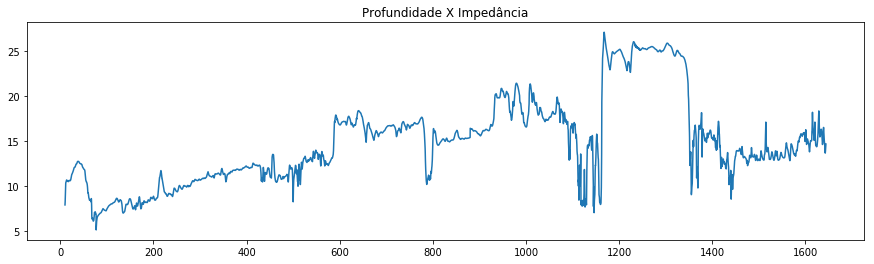

In [14]:
pylab.figure(figsize=(15,4))
pylab.plot(profundidade, impedancia)
plt.title('Profundidade X Impedância')
pylab.show()

### Reflectivity 

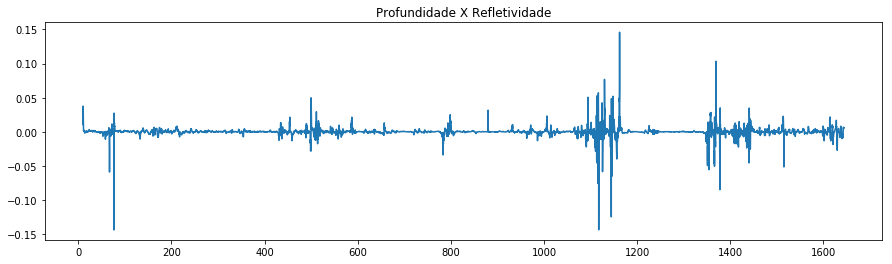

In [15]:
#Cálculo da Refletividade

RC = (impedancia[1:] - impedancia[:-1]) / (impedancia[1:] + impedancia[:-1])

pylab.figure(figsize=(15,4))
pylab.plot(profundidade[:-1], RC)
plt.title('Profundidade X Refletividade')
pylab.show()

### Relação Tempo x Profundidade

**Visualizando a Velocidade X Tempo**

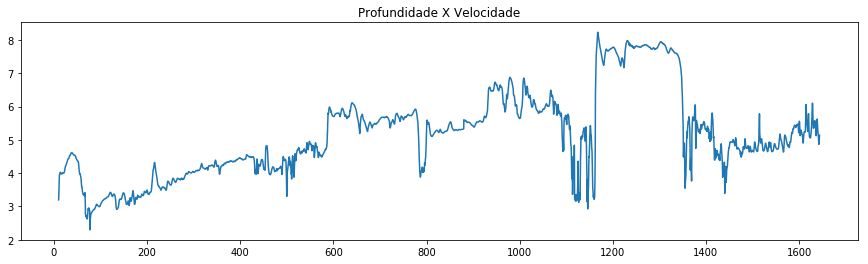

In [16]:
#c=0.7 #fator de escala
#velocidade*=c
pylab.figure(figsize=(15,4))
pylab.plot(profundidade, velocidade)
plt.title('Profundidade X Velocidade')
pylab.show()

**Transformando a escala de profundidade em tempo com a função "transf_prof_tempo"**  
Criando o primeiro vetor de tempo duplo

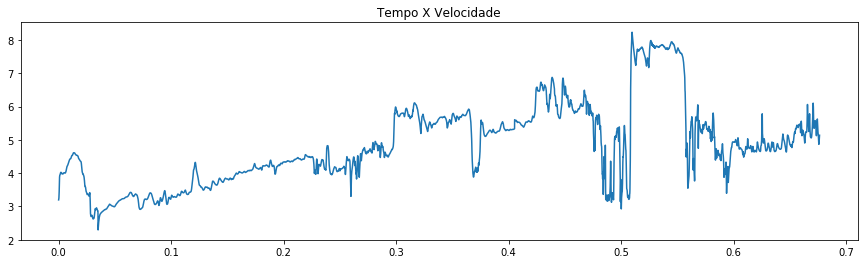

In [17]:
tempo = transf_prof_tempo(profundidade,velocidade)

pylab.figure(figsize=(15,4))
pylab.plot(tempo, velocidade)
plt.title('Tempo X Velocidade')
pylab.show()

### Filtragem e Reamostragem para 4ms
Avaliando a amostragem do **tempo original** (Calculado a partir da relação entre profundidade e velocidade), percebemos que **não existe uma taxa contínua**. Por isso, usamos uma taxa que fosse **menor do que a varíação mínima** entre amostras do tempo original para fazer uma primeira reamostragem. O valor utilizado foi de **0.06ms**. Em seguida, fizemos uma **filtragem** para **cortar altas frequências e evitar falseamento do dado**, e por fim reamostramos este dado **filtrado para 4ms**, para coincidir com a sísmica que escolhemos para amarrar.

In [18]:
np.diff(tempo) #Avaliando a taxa de amostragem do tempo original

array([  2.50400000e-04,   1.23160000e-04,   1.20560000e-04, ...,
         7.99600000e-05,   7.91200000e-05,   7.85200000e-05])

In [19]:
np.min(np.diff(tempo)) #Variação mínima do tempo original. Usar na primeira reamostragem.

4.8600000000065258e-05

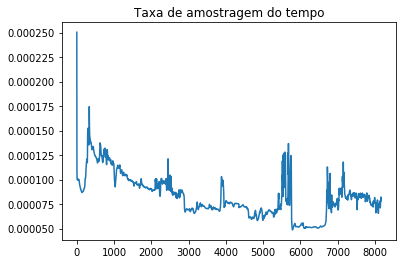

In [20]:
pylab.plot(np.diff(tempo))
plt.title('Taxa de amostragem do tempo')
pylab.show()

**Reamostragem(0.06ms) - Filtragem(100Hz) - Reamostragem(4ms)**

**impedância**: dados de impedância **original** do poço  
**Z_t**: **i**mpedância **r**eamostrada para uma taxa menor que a variação mínima da impedância original  
**Z_f**: **i**mpedância **f**iltrada com filtro passa-baixa  
**Z_fr**: **i**mpedância **f**iltrada e **r**eamostrada para 4ms  
**RC**: **r**efletividade calculada a partir dos dados de impedância original do poço  
**RC_t**: **r**efletividade **r**eamostrada para uma taxa menor que a variação mínima da impedância original  
**RC_f**: **r**efletividade **f**iltrada com filtro passa-baixa  
**RC_fr**: **r**efletividade **f**iltrada e **r**eamostrada para 4ms  
**tempo**: tempo **calculado** a partir dos arrays de profundidades e velocidades (Sônico) dos dados de poço  
**t**: **t**empo **r**eamostrado para uma taxa menor que a variação mínima da impedância original  
**tfr**: **t**empo **f**iltrado e **r**eamostrado para 4ms  

In [21]:
#-------------------REAMOSTRANDO O TEMPO (com a menor variação de tempo)----------------------#

taxa = 0.00006 #menor que a variação mínima do tempo original
(t, Z_t) = reamostra(taxa, tempo, impedancia)
RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1]) 

#-------------------FILTRO PASSA BAIXA----------------------#

N = 2    # Ordem do Filtro
fcorte=100 #Frequência de Corte

Z_f = filtro(N, fcorte, taxa, Z_t) 
RC_f = (Z_f[1:] - Z_f[:-1]) / (Z_f[1:] + Z_f[:-1]) 

#-------------------REAMOSTRANDO O TEMPO 4ms ----------------------#
taxa_r = 0.004 

(tfr, Z_fr) = reamostra(taxa_r, t, Z_f) 
RC_fr = (Z_fr[1:] - Z_fr[:-1]) / (Z_fr[1:] + Z_fr[:-1]) 

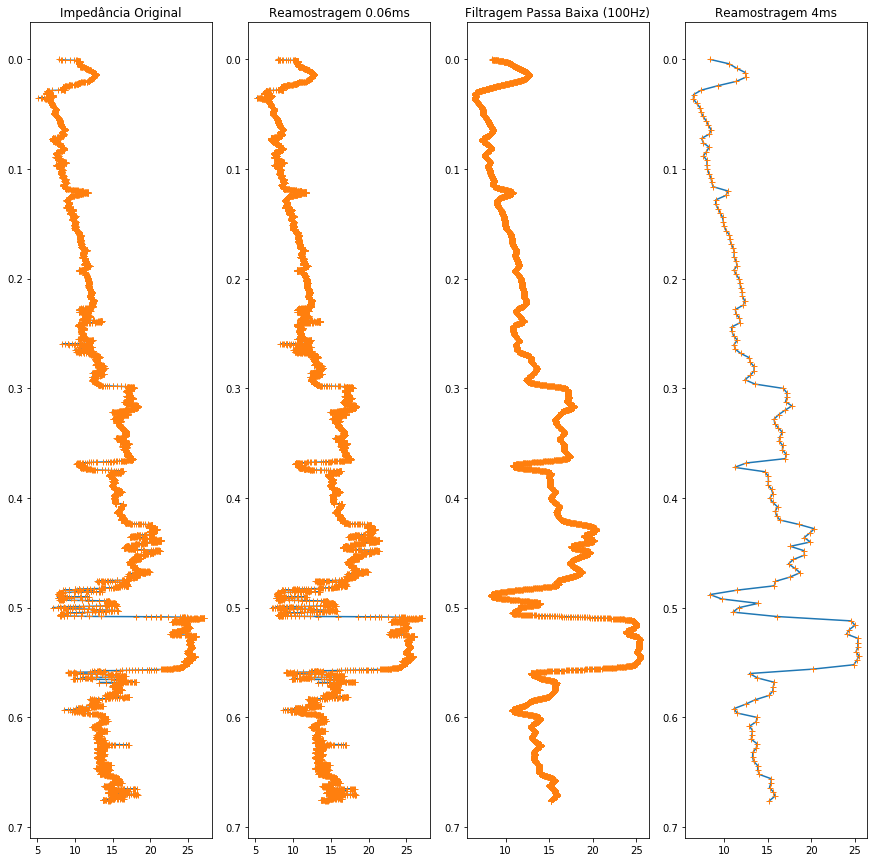

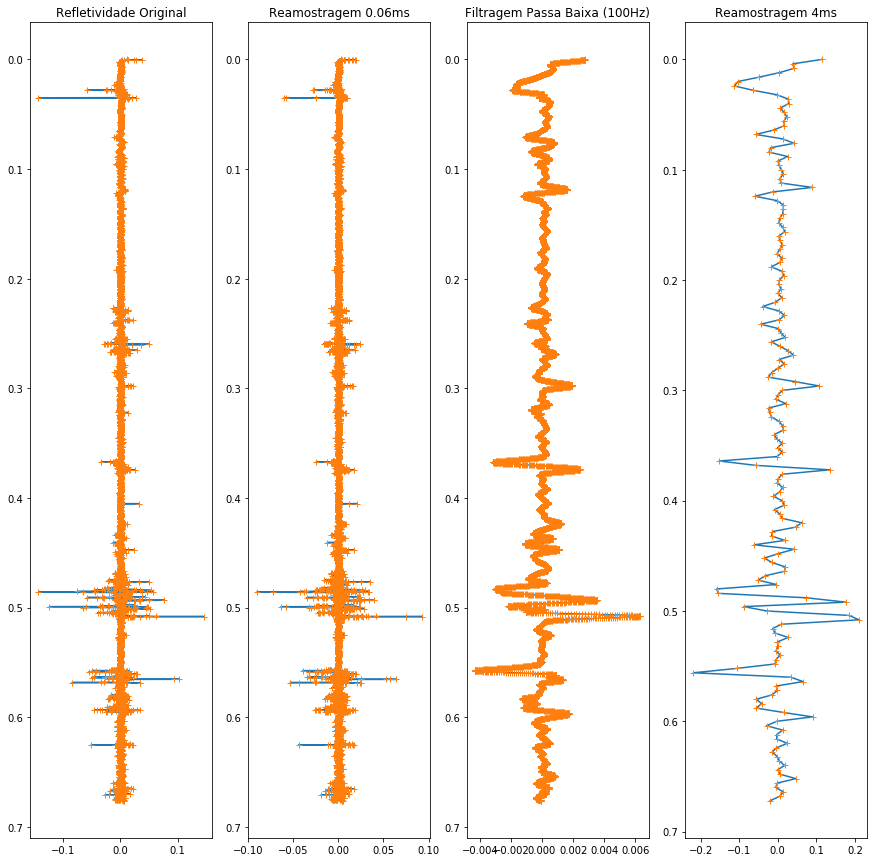

In [22]:
plot_reamostragem(impedancia, Z_t, Z_f, Z_fr, RC, RC_t, RC_f, RC_fr, tempo, t, tfr)

### Convolução

A convolução com a Ricker foi feita com uma função criada para este código, na qual você simplesmente dá o array de refletividades e recebe o perfil sintético.

In [23]:
synth = convolucao(-RC_fr)

C:\Users\rmdias\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


#### Encontrando as soleiras no tempo (função depth_time)

A partir da função depth_time, criada neste código, conseguimos descobrir o tempo referente a qualquer profundidade desejada, analisando apenas os vetores de profundidade e tempo originais. As profundidades das soleiras se encontram no pdf do perfil composto do poço. Calculamos, com isso, a posição, em tempo, das bases e topos de cada soleira.

In [24]:
s1_t = depth_time(590.0, tempo, profundidade) #topo da primeira soleira
s1_b = depth_time(785.0, tempo, profundidade) #base da primeira soleira
s2_t = depth_time(1160.0, tempo, profundidade) #topo da segunda soleira
s2_b = depth_time(1350.0, tempo, profundidade) #base da segunda soleira

soleiras=(s1_t, s1_b, s2_t, s2_b)

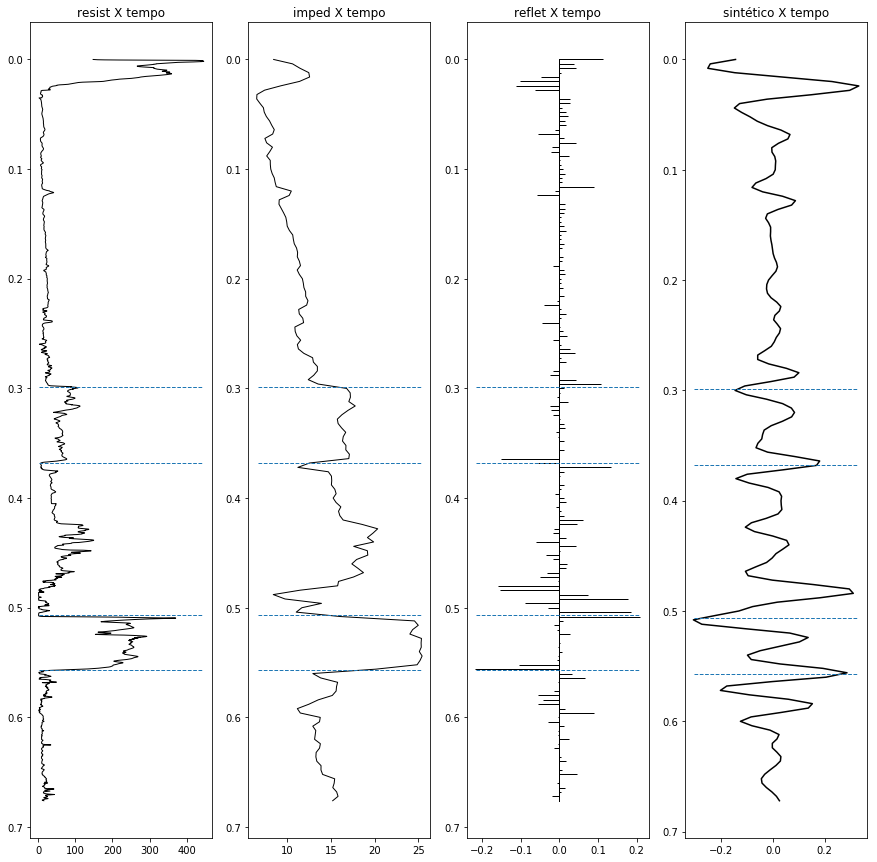

In [25]:
plot_synth_sill(resistividade, tempo, Z_fr, RC_fr, synth, tfr, soleiras)

### Carregando .segy
Esta é a linha sísmica que desejamos amarrar

In [29]:
from obspy.io.segy.segy import _read_segy

segyfile = _read_segy(r'G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\0317-0112_Cimageo\0317-0112_PSTM.sgy')
# turn ObsPy Stream in a matrix of traces
# first dimension time, second dimension traces
ntraces = len(segyfile.traces)
nsamples = len(segyfile.traces[0].data)
mtraces = np.zeros((nsamples, ntraces))
i = 0
for tr in segyfile.traces:
    mtraces[:, i] = tr.data[:]
    i += 1


### Abaixo podemos ver a sísmica e traço mais próximo do poço que desejamos amarrar.

O traço sísmico de coordenada mais próxima do poço (traço 8608) é utilizado como traço central na amarração.

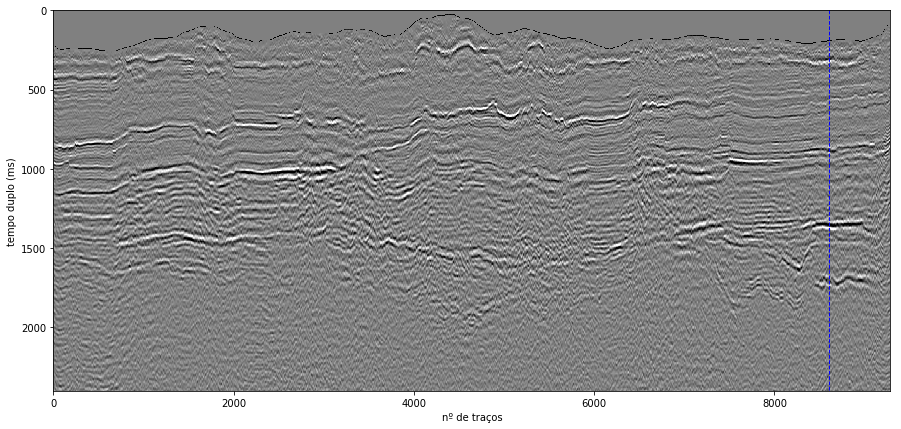

In [35]:
pylab.figure(figsize=(15,7))
pylab.imshow(mtraces[:600,:], aspect='auto', cmap=pylab.cm.gray, origin='upper', vmin=-10, vmax=10, extent=[0, 9287, 2400., 0.])
plt.plot([8608, 8608], [0, 2399], '--b', lw=1)
plt.xlabel('nº de traços')
plt.ylabel('tempo duplo (ms)')
#pylab.show()
plt.savefig('resist_parnaiba_1.png', dpi=600)

### Amarrando o Poço

Fizemos um corredor de 10 traços próximos ao traço central para analisar o sintético.

#### Slice do .segy

**namostras:** quantidade de amostras em tempo no dado sísmico  
**t_central:** traço central, sobre o qual será posicionado o perfil sintético  
**t_laterais:** quantidade de traços desejados nas laterais do traço central

In [31]:
namostras=600
t_central=8608
t_laterais=10
traces_slice=mtraces[:namostras,t_central-t_laterais:t_central+t_laterais+1]

#### Cálculo do Time Shift

+ Correção com relação ao datum final de processamento da sísmica. Os valores estão baseados no relatório da sísmica, que diz que o datum de processamento é 600m e a velocidade de substituição é 3000m/s. A elevação do poço foi retirada do pdf do Perfil Composto.  
**d_proc:** datum de processamento  
**elev:** elevação do poço  
**x1:** distância calculada em metros entre o datum de processamento e o topo do poço  
**v1:** velocida de substituição para a distância x1  

+ Correção com relação à falta de dados do poço:  
**x2:** distância em metros entre o início da perfilagem e o topo do poço  
**v2:** velocidade estimada de substituição para a distância x2  

In [32]:
d_proc=600.0
elev=260.0

x2=10.0
v2=2000.0
x1=d_proc-elev 
v1=3000.0

time_shift=2*((x2/v2)+(x1/v1)) #cálculo time shift

#### Plotando o slice do .segy com o sintético por cima

**traces_slice:** slice do segy  
**vmin, vmax:** ajeita a escala de cores  
**extent:** serve para ajustar a escala da imagem. Neste caso, a escala está sendo ajustada para coincidir com a escala de tempo, na vertical, e traços na horizontal. (20 traços para cada lado do sintético e o tempo variando de 0 a 2400ms)

+ No comando "pylab.plot" plotamos o sintético com um shift de 10 traços para a direita (10+synth) e com o time_shift calculado acima (multiplicado por 1000ms para conversão de segundos em milissegundos)
+ Para plotar as soleiras precisamos dar o mesmo time_shift para que elas ficassem posicionadas nos locais corretos com relação ao sintético


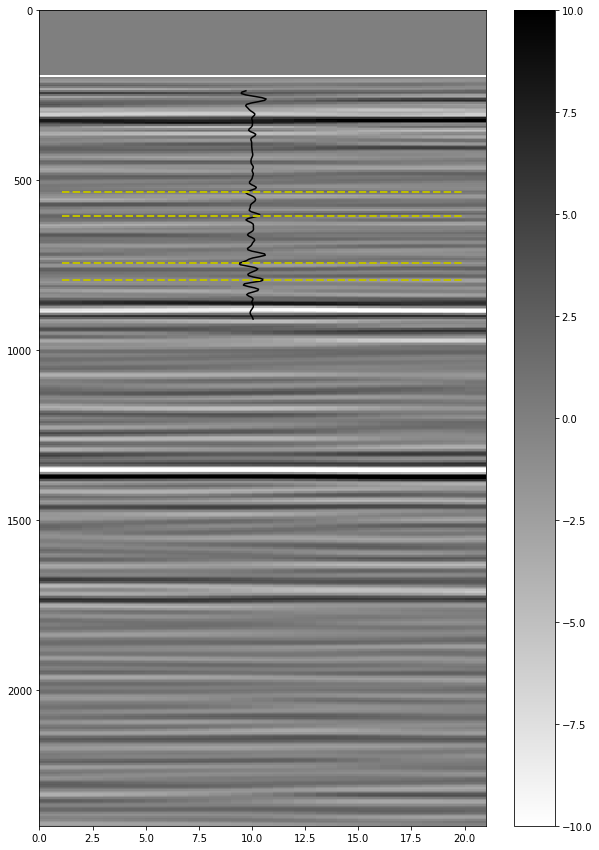

In [33]:
pylab.figure(figsize=(10,15))

pylab.imshow(traces_slice, aspect='auto', cmap=pylab.cm.gray_r, origin='upper', vmin=-10, vmax=10, extent=[0, 21, 2400., 0.])
pylab.plot(10+synth*2, time_shift*1000+np.array(range(synth.size))*4, c='k')
plt.colorbar()
for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.05, xmax = 0.95, lw=2,  c='y', ls='--')

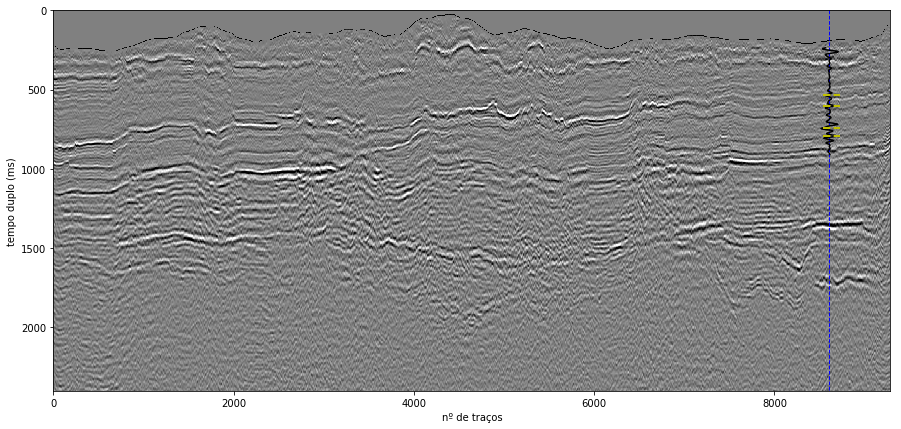

In [34]:
pylab.figure(figsize=(15,7))
pylab.imshow(mtraces[:600,:], aspect='auto', cmap=pylab.cm.gray, origin='upper', vmin=-10, vmax=10, extent=[0, 9287, 2400., 0.])
plt.plot([8608, 8608], [0, 2399], '--b', lw=1)
pylab.plot(8608+synth*300, time_shift*1000+np.array(range(synth.size))*4, c='k')
for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.92, xmax = 0.94, lw=2,  c='y', ls='--')
plt.xlabel('nº de traços')
plt.ylabel('tempo duplo (ms)')
#pylab.show()
plt.savefig('resist_parnaiba_1.png', dpi=600)

## Discussão dos Resultados e Conclusões

#### Analisando as velocidades das soleiras

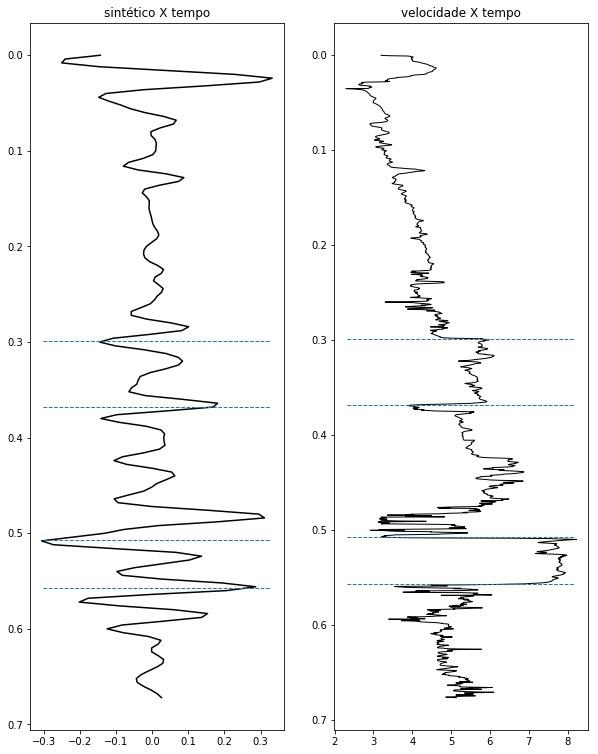

In [36]:
pylab.figure(figsize=(10,13))

pylab.subplot(1,2,1)
pylab.plot(synth, tfr[:-1], c='k')
plt.title('sintético X tempo')
for i in range(len(soleiras)):
    plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
plt.gca().invert_yaxis()

pylab.subplot(1,2,2)
pylab.plot(velocidade, tempo, c='k', lw=1)
plt.title('velocidade X tempo')
for i in range(len(soleiras)):
    plt.axhline(y = soleiras[i], xmin = 0.05, xmax = 0.95, lw=1, ls='--')
plt.gca().invert_yaxis()

pylab.show()

In [37]:
v_sol1=(785-590)*2/(s1_b-s1_t)
v_sol2=(1350-1160)*2/(s2_b-s2_t)
print('v. média soleira 1:', v_sol1,'m/s',',', 'v. média soleira 2:', v_sol2,'m/s')

v. média soleira 1: 5663.31011473 m/s , v. média soleira 2: 7551.41119978 m/s


Comparando com outros poços próximos, nos quais a velocidade das soleiras estão na casa de 5000m/s a 6000m/s, concluimos que a velocidade da primeira soleira no poço deste trabalho está muito abaixo do normal. Analisando os gráficos do traço sintético e das velocidades no poço, percebemos que a velocidade da primeira soleira está na casa dos 3900m/s, enquanto a segunda soleira está normal, com velocidade próxima a 6000m/s. Além disso, ao interpretar a sísmica e o corredor de traços, assumimos que as soleiras estariam localizadas nas reflexões de maior contraste, porém os limites das soleiras (plotados em azul tracejado) não combinavam com as reflexões mais fortes. Esta grande diferença nas velocidades das soleiras junto com a análise do corredor de traços a princípio nos levou a crer que as aproximações de Gardner e de Faust para transformar Resistividade em Vagarosidade fossem muito simples para que o poço fosse amarrado corretamente.

Porém, havia um problema nesta teoria: se a velocidade era menor do que a esperada, o traço sintético deveria estar mais "espichado", o que faria com que as soleiras (plotadas em azul) aparecessem abaixo das reflexões mais fortes. Ao invés disso, as soleiras apareciam acima das reflexões, na análise do corredor de traços, o que não fazia sentido. Então, voltando a analisar o log de resistividade, percebemos que a resistividade da primeira soleira também era mais baixa, assim como a velocidade, quando deveria ter valores próximos aos da segunda soleira. Isto poderia significar que na verdade as aproximações de Gardner e Faust estariam corretas e que o problema estaria nos dados originais (talvez uma diminuição na resistividade por causa da lama de perfuração), e por isso seria impossível amarrar o poço.

#### Última tentativa: Comparando linha original e reprocessamento no _Petrel_

Ainda assim, decidimos fazer uma última tentativa, desta vez no Petrel. Carregamos duas linhas sísmicas (processamento original e reprocessamento), os dados originais de resistividade e utilizamos as mesmas relações de Gardner e Faust para chegar ao perfil sônico e criar o sintético exatamente igual ao que havia sido criado com o Python. Porém, ao abrir a linha sísmica no Petrel logo fizemos uma interpretação diferente, pois havia claramente uma soleira definida em outra posição, acima da primeira reflexão mais forte. Desta vez, ao plotar o perfil sintético junto com o corredor de traços e também por cima da própria linha sísmica, pudemos perceber que as soleiras que interpretamos por último (sem ser a maior reflexão) encaixava quase perfeitamente com o sintético.

#### Processamento Geokinectics (2013)

In [38]:
#from IPython.display import Image
#from IPython.core.display import HTML

In [39]:
#Image(filename = PATH + "G:\Equipe\Raquel Macedo\POCOS_AMARRAR\Parnaiba\geokinectics.png", width=800, height=800)

#### Processamento Cimageo (2017)

In [40]:
#Image(filename = PATH + "\geokinectics.png", width=800, height=800)

In [41]:
#PATH = r"G:\Equipe\Raquel Macedo\POCOS_AMARRAR"
#Image(filename = PATH + "\cimageo.png", width=800, height=800)

Dessa forma, podemos concluir que a ideia de criar um perfil sônico a partir do log de resistividade do poço, utilizando as relações de Gardner e Faust, pode ser suficiente para amarrar o poço à sísmica, desde que seja utilizada uma forma de visualização melhor. Também concluímos que não se deve deixar levar pela primeira reflexão de maior contraste para a amarração, pois tudo se baseia no contraste de impedância: pode haver alguma rocha densa antes da soleira, gerando um contato que não dê uma resposta de impedância muito forte na linha sísmica, o que pode não chamar a mesma atenção do que um contraste forte.

Além disso, como comparamos dois processamentos diferentes da mesma linha sísmica, chegamos a algumas conclusões também sobre como a qualidade do processamento pode contribuir para (ou atrapahar) a amarração de poços. Na linha original (geokinectics) os topos e bases de cada soleira do sintético estão mais próximos aos refletores correspondentes às soleiras na sísmica, e estes refletores por sua vez estão bem mais fortes, o que facilita bastante a amarração. A desvantagem de se usar a linha original foi o datum de processamento, que foi setado no nível do mar, causando um ruído muito confuso na parte superior do dado e impossibilitando a amarração na parte rasa do poço. Já no reprocessamento (cimageo), o datum de processamento utilizado foi 600m acima do nível do mar, conservando assim os dados de 0m à 260m (valor da topografia no poço). Considerando que a alitude na localização do poço era de 260m, havia um espaço de 340m de "sobra" na linha sísmica, o que possibilitou um melhor imageamento das regiões mais rasas e uma melhor amarração nesta região. Porém, este reprocessamento não imageou tão bem as soleiras, o que desviou a atenção para outros refletores mais fortes que não tinham relação com as soleiras, e dificultou a amarração.

## VSP Checkshot

#### Completando o vetor de velocidades até a profundidade zero. (Não precisa porque neste perfil o log já está começando próximo do zero)

vel_original = np.append(np.zeros(1300)+3000, velocidade)[::-1]
vel_original = vel_original[::-1]

prof_original = np.append(np.arange(0, 260, 0.2), profundidade)[::-1]
prof_original = prof_original[::-1]

pylab.figure(figsize=(15,5))
pylab.plot(prof_original, vel_original)
plt.title('Profundidade X Velocidade')

#### Nova relação tempo profundidade feita a partir do array de velocidades completado. (Não precisa pq não precisei completar)

temp_original = transf_prof_tempo(prof_original[:-1],vel_original)

pylab.figure(figsize=(15,4))
pylab.plot(tempo, velocidade)
plt.title('Tempo X Velocidade')
pylab.show()

In [42]:
twt_perfildt = tempo
md_perfildt = profundidade
vel_perfildt = velocidade*1000

In [46]:
#### Carregando a tabelinha do VSP para calcular o drift

checkshot = np.loadtxt('G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\\1-FL-1-PI\checkshot_1FL0001PI.csv', 
                       delimiter=';')

#DADOS DO CHECKSHOT
md_vsp = checkshot[:,0]
twt_vsp = checkshot[:,1]*0.001

vel_vsp = (md_vsp[1:] - md_vsp[:-1])*2 / (twt_vsp[1:] - twt_vsp[:-1])
vel_vsp = np.append(vel_vsp, vel_vsp[-1])

In [47]:
#Retirando do checkshot as amostras que completavam até o datum sísmico
vel_vsp = vel_vsp[np.where(np.logical_and(md_vsp >=0, md_vsp <=1644))]
md_vsp = md_vsp[np.where(np.logical_and(md_vsp >=0, md_vsp <=1644))]
twt_vsp = transf_prof_tempo(md_vsp, vel_vsp*0.001)

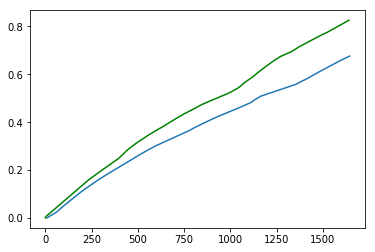

In [48]:
plt.plot(md_perfildt, twt_perfildt)
plt.plot(md_vsp, twt_vsp, 'g')

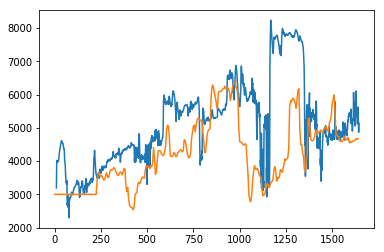

In [49]:
plt.plot(md_perfildt, vel_perfildt)
plt.plot(md_vsp, vel_vsp)

In [50]:
#Descobrindo os tempos no sônico com a mesma profundidade do VSP (só para plotar as cruzezinhas)

def graph_drift(twt_vsp, md_vsp, md_perfildt, twt_perfildt):
    """
    Extrai do sônico os tempos correspondentes às profundidades do VSP
    
    """
    temp_sonico=np.zeros(twt_vsp.size)
    for i in range (len(twt_vsp)):
        temp_sonico[i] = np.interp(md_vsp[i], md_perfildt, twt_perfildt)    
    temp_sonico=temp_sonico
    return (twt_vsp-temp_sonico)*1000

In [51]:
graph_twt_drift = graph_drift(twt_vsp, md_vsp, md_perfildt, twt_perfildt)
#Cálculo do drift com interpolação do VSP
twt_drift = ((np.interp(md_perfildt, md_vsp, twt_vsp))-twt_perfildt)*1000

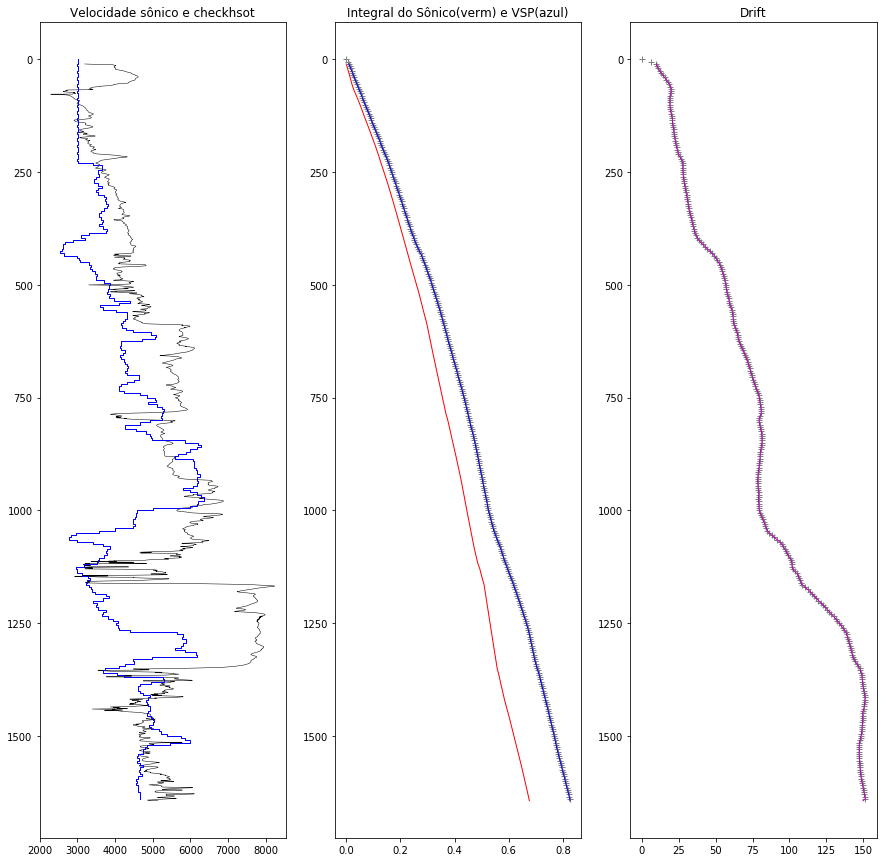

In [52]:
pylab.figure(figsize=(15,15))
pylab.subplot(1,3,1)
pylab.plot(vel_perfildt, md_perfildt, c='k', lw=0.5)
# checkshot in steps
plt.plot(np.repeat(vel_vsp, 2)[:-1], np.append(md_vsp[0], np.repeat(md_vsp[1:], 2)), c='b', lw=1)
plt.title('Velocidade sônico e checkhsot')
plt.gca().invert_yaxis()

pylab.subplot(1,3,2)
pylab.plot(twt_perfildt, md_perfildt, c='r', lw=1)
pylab.plot(twt_vsp, md_vsp, '+', c='gray')
pylab.plot(np.interp(md_perfildt, md_vsp, twt_vsp), md_perfildt, c='b', lw=1)
plt.title('Integral do Sônico(verm) e VSP(azul)')
plt.gca().invert_yaxis()

pylab.subplot(1,3,3)
pylab.plot(graph_twt_drift, md_vsp, '+', c='gray')
pylab.plot(twt_drift, md_perfildt, c='m', lw=1)
plt.title('Drift')
plt.gca().invert_yaxis()

pylab.show()

#### Regressão linear no Drift para correção das velocidades
CONSERTAR TUDO

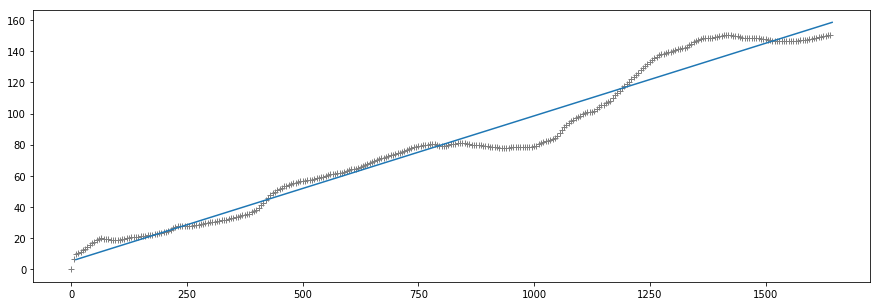

In [53]:
pylab.figure(figsize=(15,5))

vsp_time_drift = (twt_vsp-graph_twt_drift)
vsp_depth_drift = md_vsp
plt.plot(vsp_depth_drift, -vsp_time_drift, '+', c='gray')
coefs_1 = np.polyfit(vsp_depth_drift, vsp_time_drift, 1)
plt.plot(md_perfildt, -np.polyval(coefs_1, md_perfildt))

In [54]:
twt_corrigido = (twt_perfildt*1000 + np.polyval(coefs_1, md_perfildt))

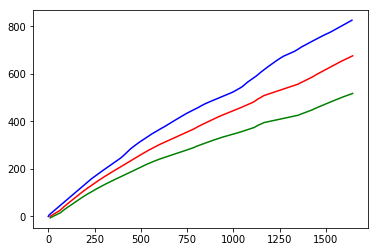

In [55]:
plt.plot(md_vsp, twt_vsp*1000, 'b')
plt.plot(md_perfildt, twt_perfildt*1000, 'r')
plt.plot(md_perfildt, twt_corrigido, 'g')

In [56]:
vel_corrigida = np.diff(md_perfildt)/ (np.diff(twt_corrigido)*0.001*0.5)

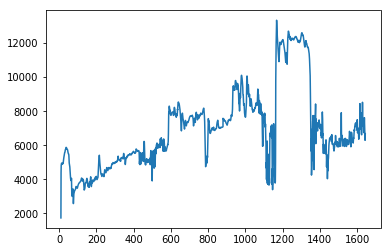

In [57]:
plt.plot(md_perfildt[:-1], vel_corrigida)

In [58]:
graph_twt_driftnovo = graph_drift(twt_vsp, md_vsp, md_perfildt, twt_corrigido*0.001)
twt_drift_novo = (np.interp(md_perfildt, md_vsp, twt_vsp)*1000-twt_corrigido)

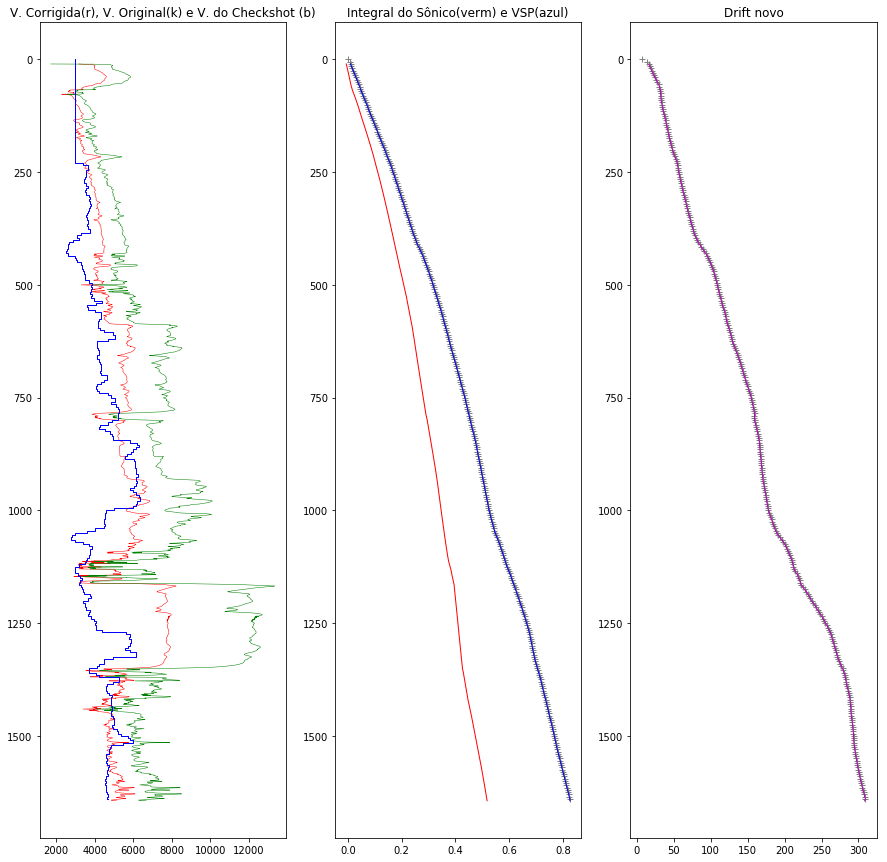

In [59]:
pylab.figure(figsize=(15,15))

pylab.subplot(1,3,1)
pylab.plot(vel_perfildt, md_perfildt, c='r', lw=0.5)
pylab.plot(vel_corrigida, md_perfildt[:-1], c='g', lw=0.5)
plt.plot(np.repeat(vel_vsp, 2)[:-1], np.append(md_vsp[0], np.repeat(md_vsp[1:], 2)), c='b', lw=1)
plt.title('V. Corrigida(r), V. Original(k) e V. do Checkshot (b)')
plt.gca().invert_yaxis()

pylab.subplot(1,3,2)
pylab.plot(twt_corrigido*0.001, md_perfildt, c='r', lw=1)
pylab.plot(twt_vsp, md_vsp, '+', c='gray')
pylab.plot((np.interp(md_perfildt, md_vsp, twt_vsp)), md_perfildt, c='b', lw=1)
plt.title('Integral do Sônico(verm) e VSP(azul)')
plt.gca().invert_yaxis()

pylab.subplot(1,3,3)
pylab.plot(graph_twt_driftnovo, md_vsp, '+', c='gray')
pylab.plot(twt_drift_novo, md_perfildt, c='m', lw=1)
plt.title('Drift novo')
plt.gca().invert_yaxis()

In [60]:
np.savetxt('sonico_corrigido', vel_corrigida)